In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sklearn
from scipy import ndimage, misc
import math
%matplotlib inline
import cv2
import time
import glob

img_list = []
filenamelist= []
for img in glob.glob("0518ALL_Data/CCD-3/*.jpg"):
    #img_list.append(cv2.imread(img,0))
    filenamelist.append(img)
np.array(filenamelist).shape

(1011,)

0525_images/CCD-3/ALL/0.jpg


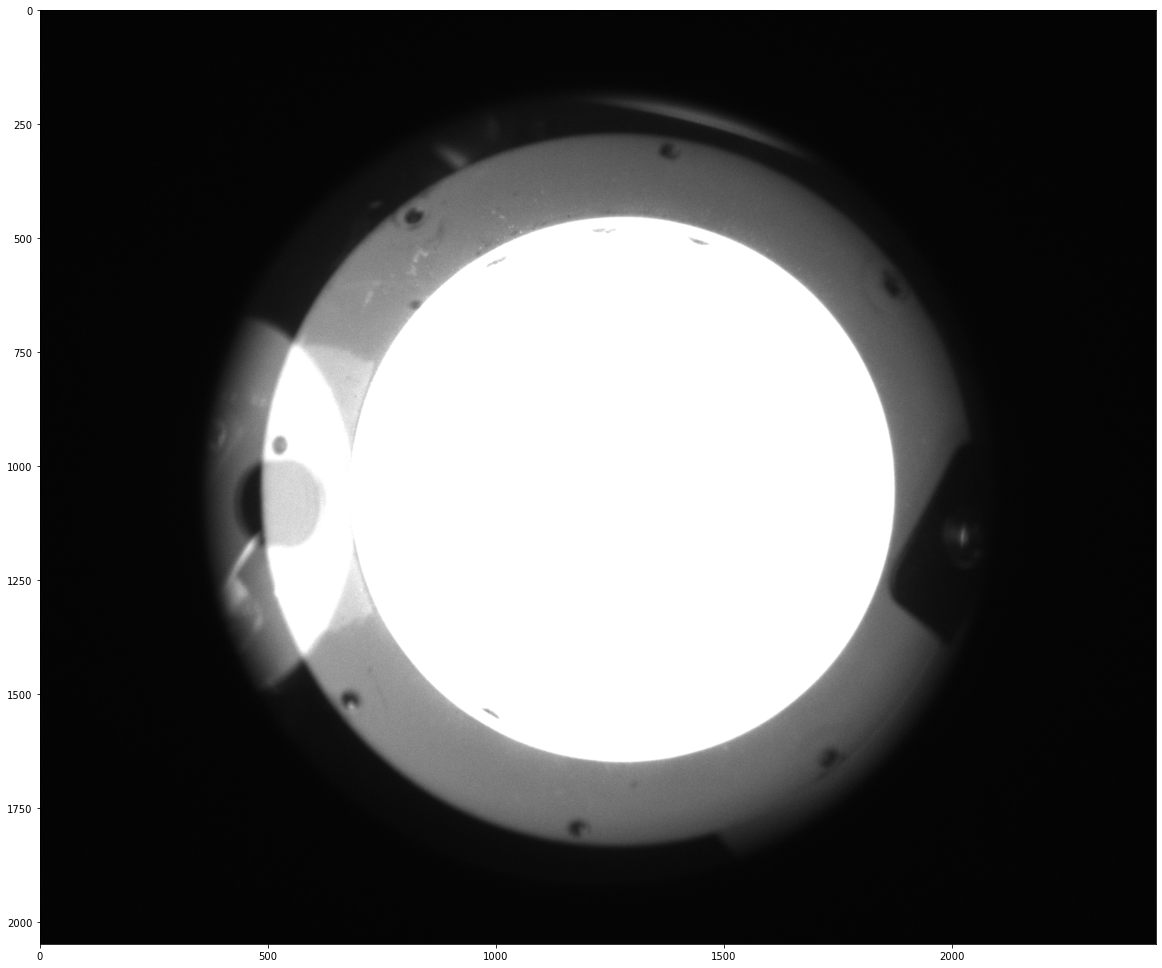

In [3]:
filename = '0525_images/CCD-3/ALL/0.jpg'
print(filename)
background = np.array(cv2.imread(filename,0))


plt.figure(figsize=(20,20))
plt.imshow(background,cmap = 'gray')


0525_images/CCD-3/18.jpg
418545.5
[9232]
417943.0
[9232, 9233]
615.0
[9232, 9233, 9243]
625.0
[9232, 9233, 9243, 9252]
367   1227   1063
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan


'\n1.找到那一圈黑色的\n2.找外接圓\n3.從圓心往外射，看射到的pixel 0 和255分布(0太少表示是斷裂)\n\n想法:degree太少，插入幾根在這些degree當中(本來是1度一單位)\n'

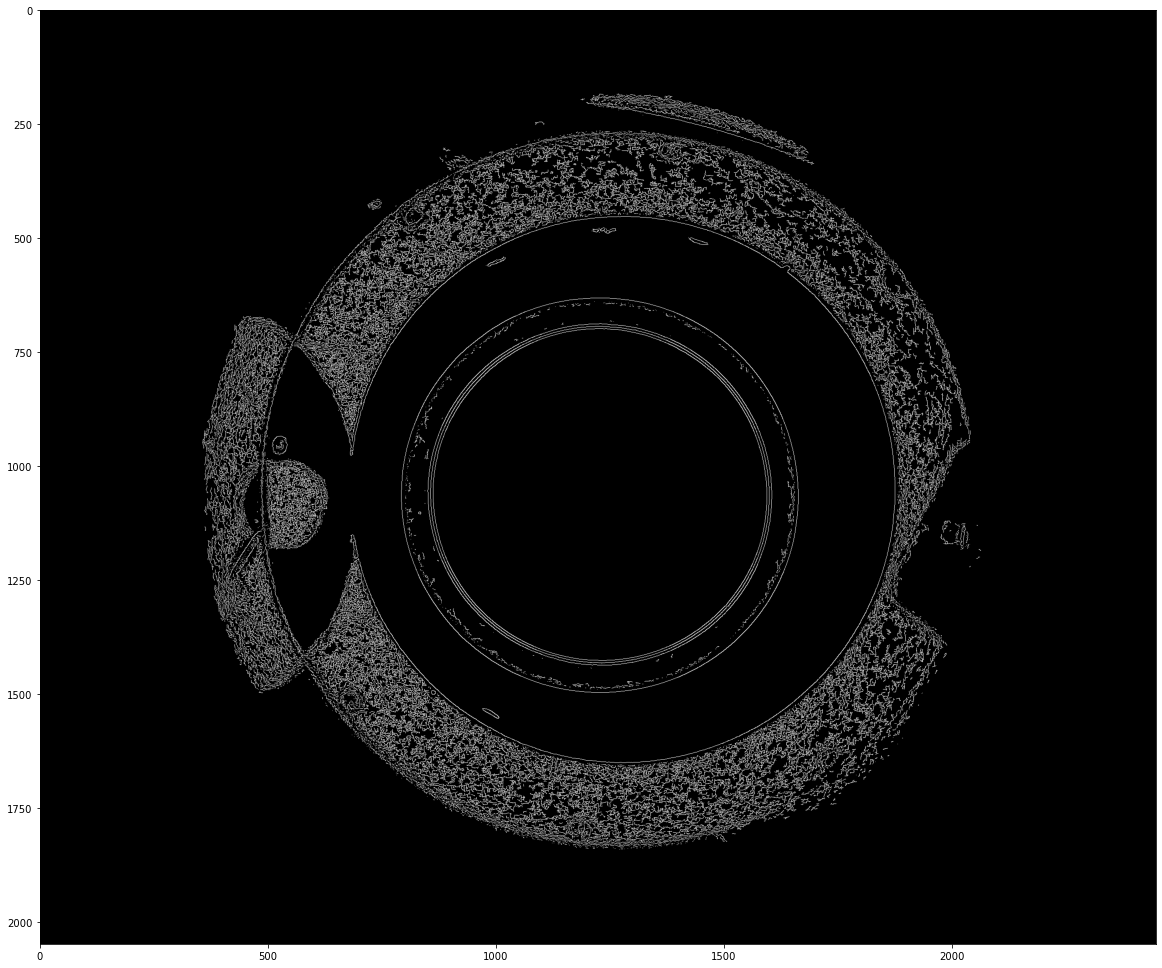

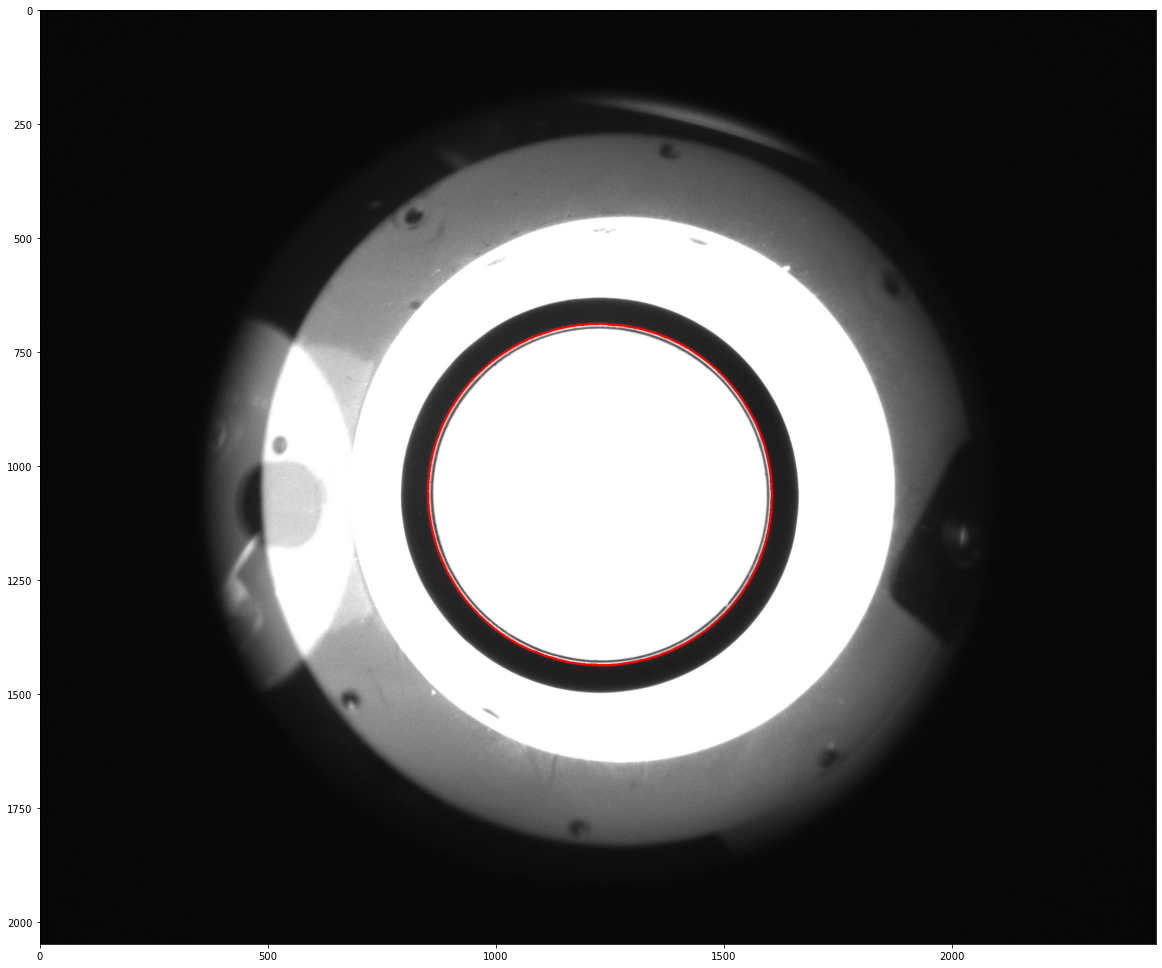

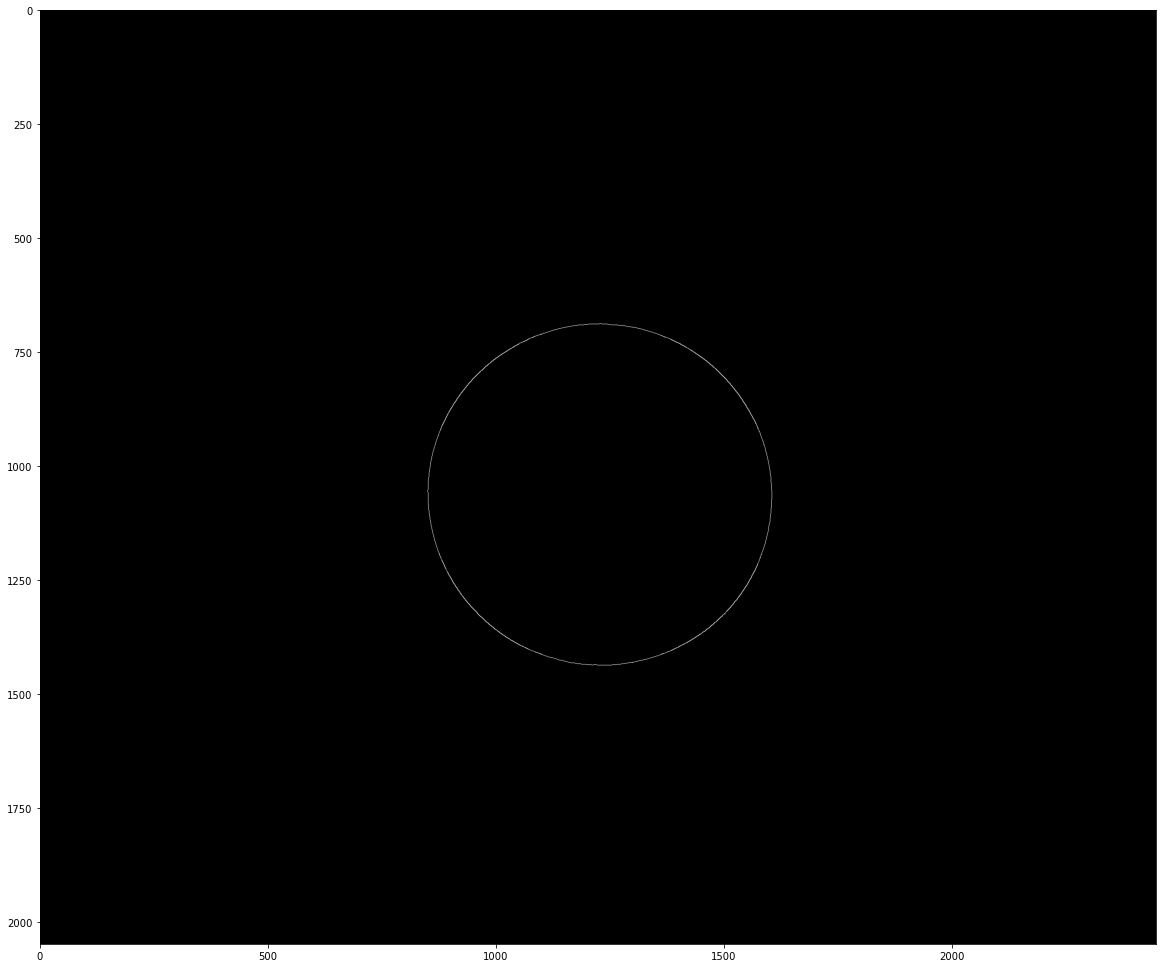

<Figure size 1440x1440 with 0 Axes>

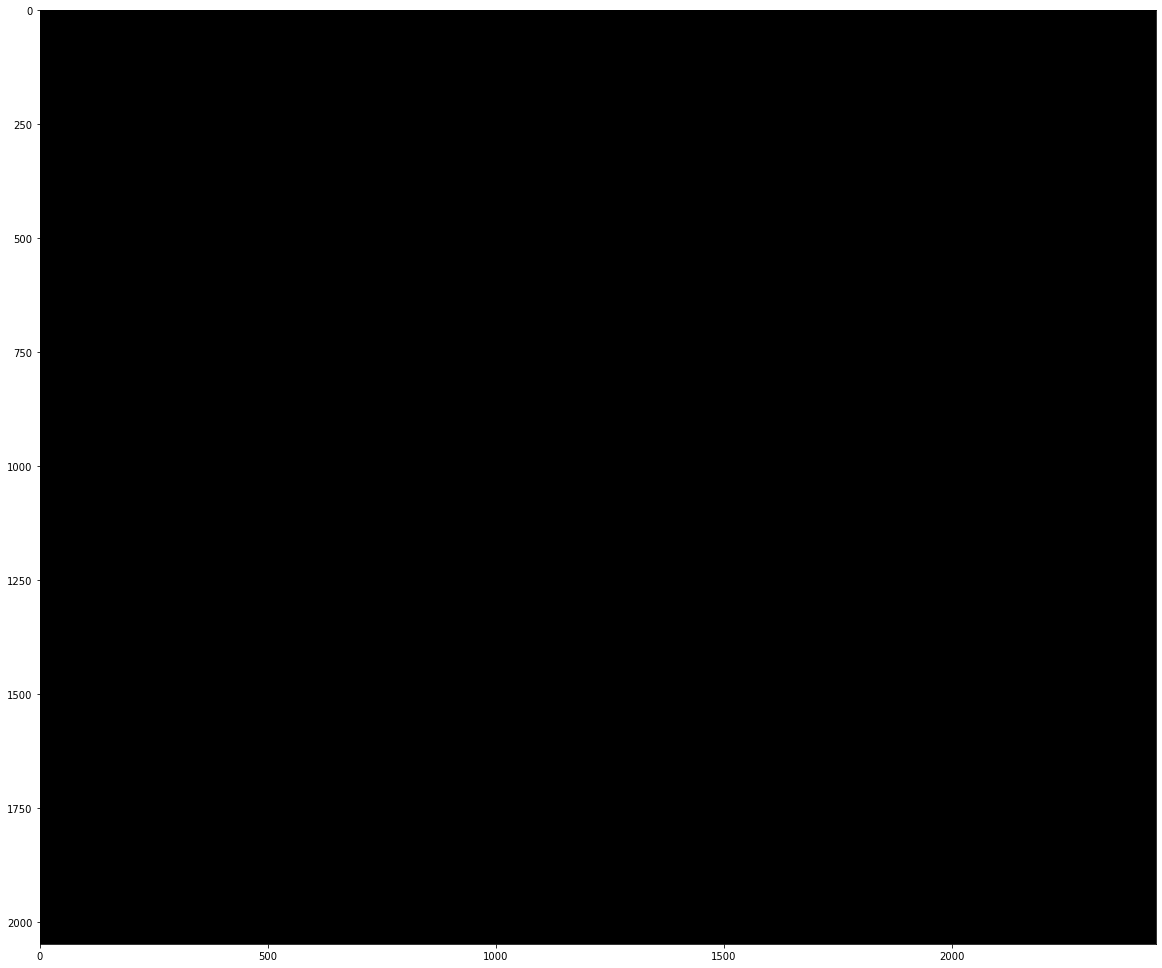

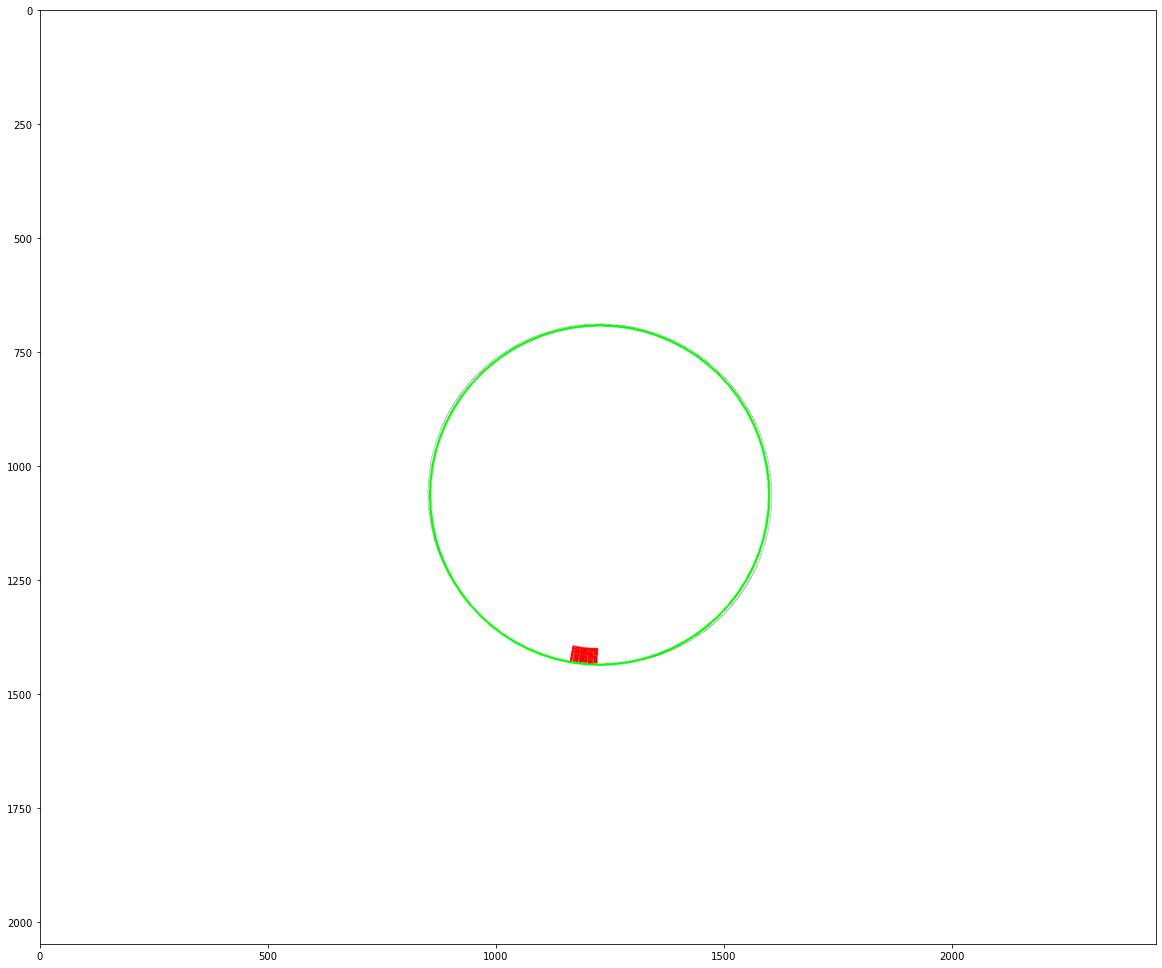

In [140]:
filename = '0525_images/CCD-3/18.jpg'
print(filename)
image = np.array(cv2.imread(filename,0))
backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

#==============================================先用canny找出輪廓=============================================

#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')

image_blur = cv2.blur(image,(5,5))
canny = cv2.Canny(image_blur,5,15)
plt.figure(figsize=(20,20))
plt.imshow(canny,cmap = 'gray')

#==============================================用findcontours把canny得到的 ROI切出來=======================================

_ , contours, hierarchy = cv2.findContours(canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
inner_contours_final = []
approx_list = []
index = []
for i in range(np.array(contours).shape[0]):
    if (hierarchy[0][i][3] >= 0):
        if(cv2.contourArea(contours[i])>500 and cv2.contourArea(contours[i])<500000):
            #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
            #inner_contours_final.append(contours[i])
            epsilon = 0.005# * cv2.arcLength(contours[i],True)
            index.append(i)
            approx = cv2.approxPolyDP(contours[i], epsilon, True)
            print(cv2.contourArea(approx))
            approx_list.append(approx)
            #print(np.array(approx_list).shape)
            print(index)
            if(i==9252):
                cv2.polylines(backtorgb, [approx], True, (255,0, 0), 3)

plt.figure(figsize=(20,20))
plt.imshow(backtorgb)

#==========================================外圓減內圓(外圓是面積最大那一個，index = 0 ，內圓面積最小，index = -1)

inner_contour_img = np.zeros_like(image)
cv2.drawContours(inner_contour_img, [approx_list[-1]],-1,(0,0,0),-1)
#inner_contour_img = 1 - inner_contour_img

outer_contour_img = np.zeros_like(image)
cv2.drawContours(outer_contour_img, [approx_list[-1]],-1,(255,255,255),-1)
#outer_contour_img = 1 - outer_contour_img

#outer - inner
#oringmask = outer_contour_img- inner_contour_img
oringmask = outer_contour_img

\plt.figure(figsize=(20,20))
plt.imshow(oringmask,cmap = 'gray')


mask_image = oringmask*image
#mask_image = 1 - mask_image
image[oringmask == 0] =255
plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')
#plt.imsave("temp.jpg",image,cmap = 'gray')
backtorgb_inner_oring = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
#==========================================找外接圓==============================================
ret, thresh1 = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY_INV)

c,r = cv2.minEnclosingCircle(approx_list[0])
r = int(r)
cx = int(c[0])
cy = int(c[1])
print(r," ",cx," ",cy)
cv2.circle(backtorgb_inner_oring,(cx,cy),(r+5), (0,255 ,0), 3)

#================================================從圓心射線================================
image = cv2.blur(image,(3,3))
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
image = cv2.filter2D(image, -1, kernel)
#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')


ret, image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY_INV)

open_kernel = np.ones((2,3),np.uint8)
#open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,3))
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, open_kernel)

plt.figure(figsize=(20,20))
plt.imshow(image,cmap = 'gray')
plt.imsave("temp.jpg",thresh1,cmap = 'gray')

#=====blur image=====
#image = cv2.blur(image,(2,3))
#=====================

const = np.pi/180
x = []
y = []
inner_x = []
inner_y = []

for degree in range(360):
    
    now_x = int((r+2)*np.sin(degree*const))+cx
    now_y = int((r+2)*np.cos(degree*const))+cy
    now_inner_x = int((r-30)*np.sin(degree*const))+cx
    now_inner_y = int((r-30)*np.cos(degree*const))+cy
    
    if(degree>0):
        prev_x = x[-1]
        prev_y = y[-1]
        prev_inner_x = inner_x[-1]
        prev_inner_y = inner_y[-1]
        
        x.append((now_x+prev_x)//2)
        y.append((now_y+prev_y)//2)
        inner_x.append((now_inner_x+prev_inner_x)//2)
        inner_y.append((now_inner_y+prev_inner_y)//2)
        
    x.append(now_x)
    y.append(now_y)
    inner_x.append(now_inner_x)
    inner_y.append(now_inner_y)

for degree in range(719):
    points_on_line = np.linspace((inner_x[degree], inner_y[degree]),(x[degree],y[degree]) ,200,dtype = int)
    pass_list = image[points_on_line[:,1],points_on_line[:,0]]
    if(degree >= 700 and degree <=720):
    #if(sum(pass_list[pass_list<120])<=5000 and sum(pass_list[pass_list<120])>=4000):
    #if(np.mean(pass_list[pass_list<230])>150):
    #if(len(pass_list[pass_list==255])<15):
        #cv2.line(backtorgb_inner_oring,(cx,cy),(x,y),255,2)
        print(len(pass_list[pass_list==255])," ", np.mean(pass_list[pass_list==255]))
        cv2.line(backtorgb_inner_oring,(inner_x[degree],inner_y[degree]),(x[degree],y[degree]),255,2)
        #cv2.circle(backtorgb_inner_oring,(x,y),30, (0,255 ,255), 5)
        #print(np.mean(pass_list[pass_list<100]))
        #print(sum(pass_list[pass_list<80]))

plt.figure(figsize=(20,20))
plt.imshow(backtorgb_inner_oring)
plt.imsave("stop3.jpg",backtorgb_inner_oring)
#======================pipeline========================
'''
1.找到那一圈黑色的
2.找外接圓
3.從圓心往外射，看射到的pixel 0 和255分布(0太少表示是斷裂)

想法:degree太少，插入幾根在這些degree當中(本來是1度一單位)
'''
#======================parameter=======================



0525_images/CCD-3/5.jpg
Area:  596183.5
Area:  420818.0
444016.0
443387.0
421851.5
421234.0
603.5


IndexError: list index out of range

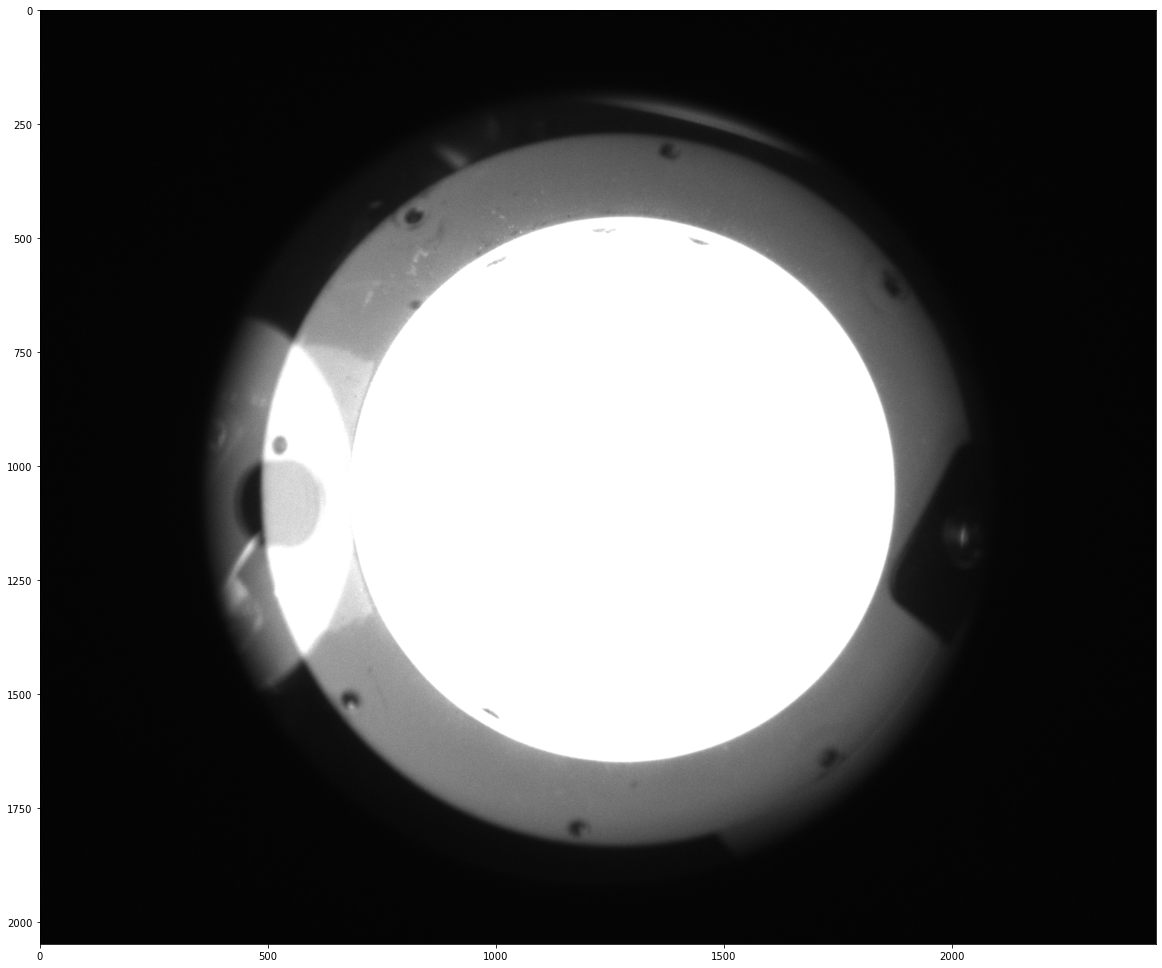

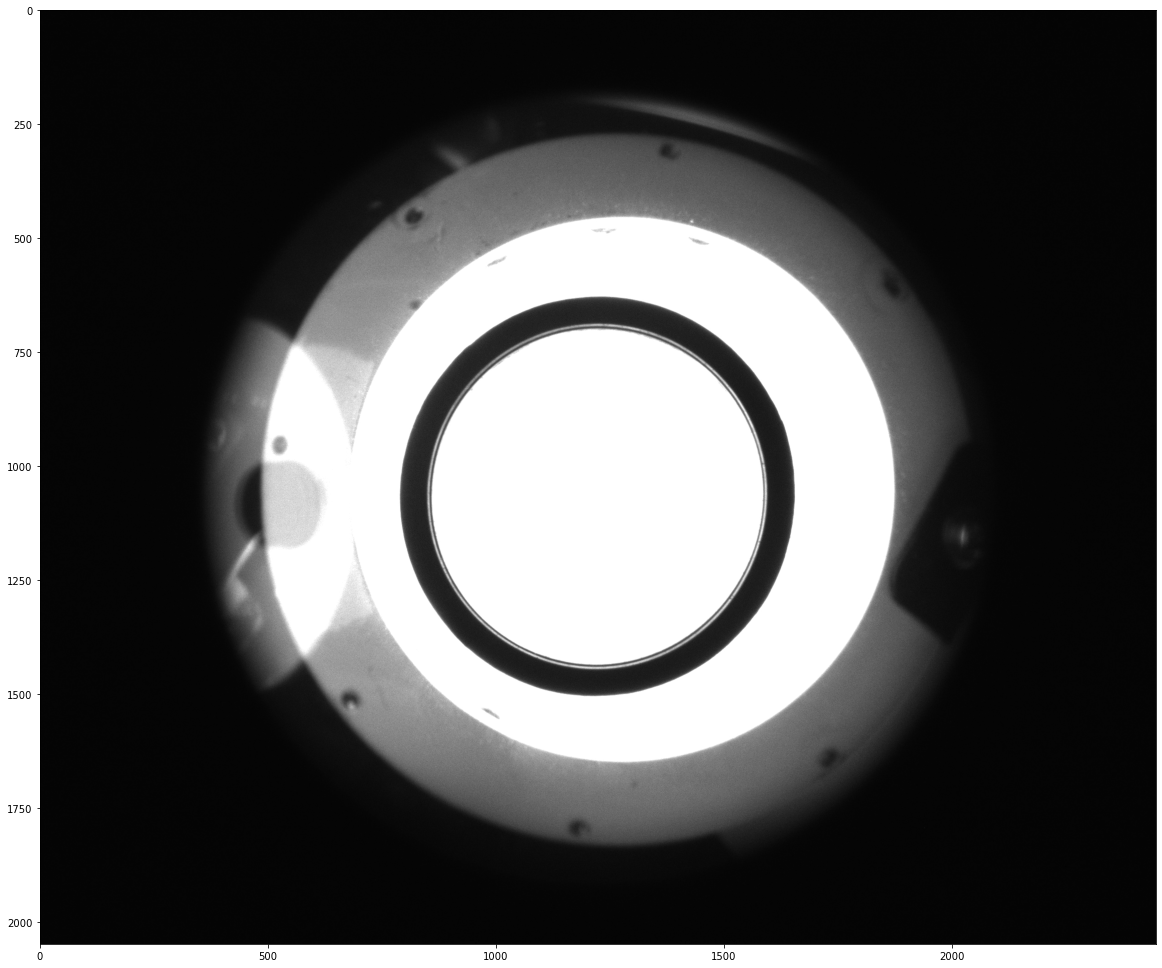

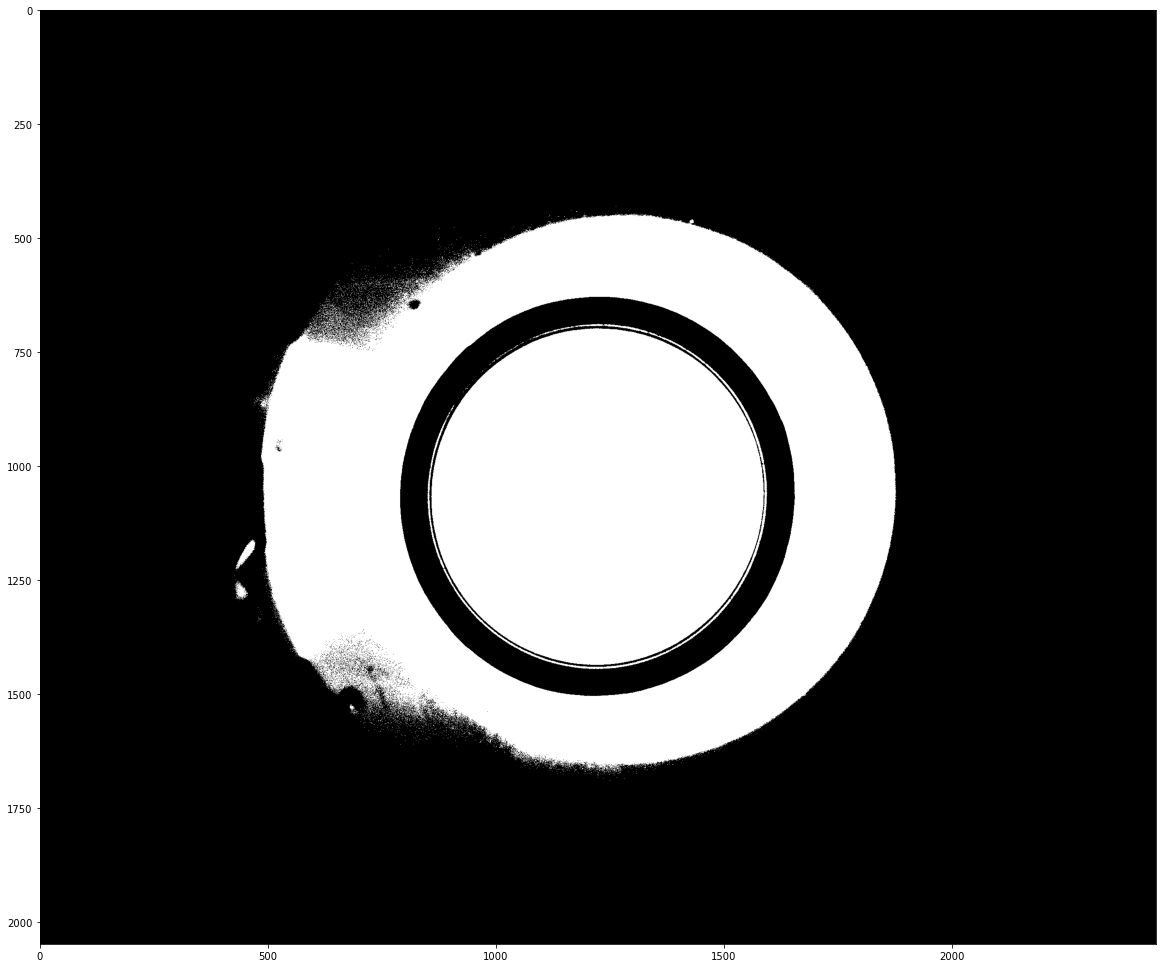

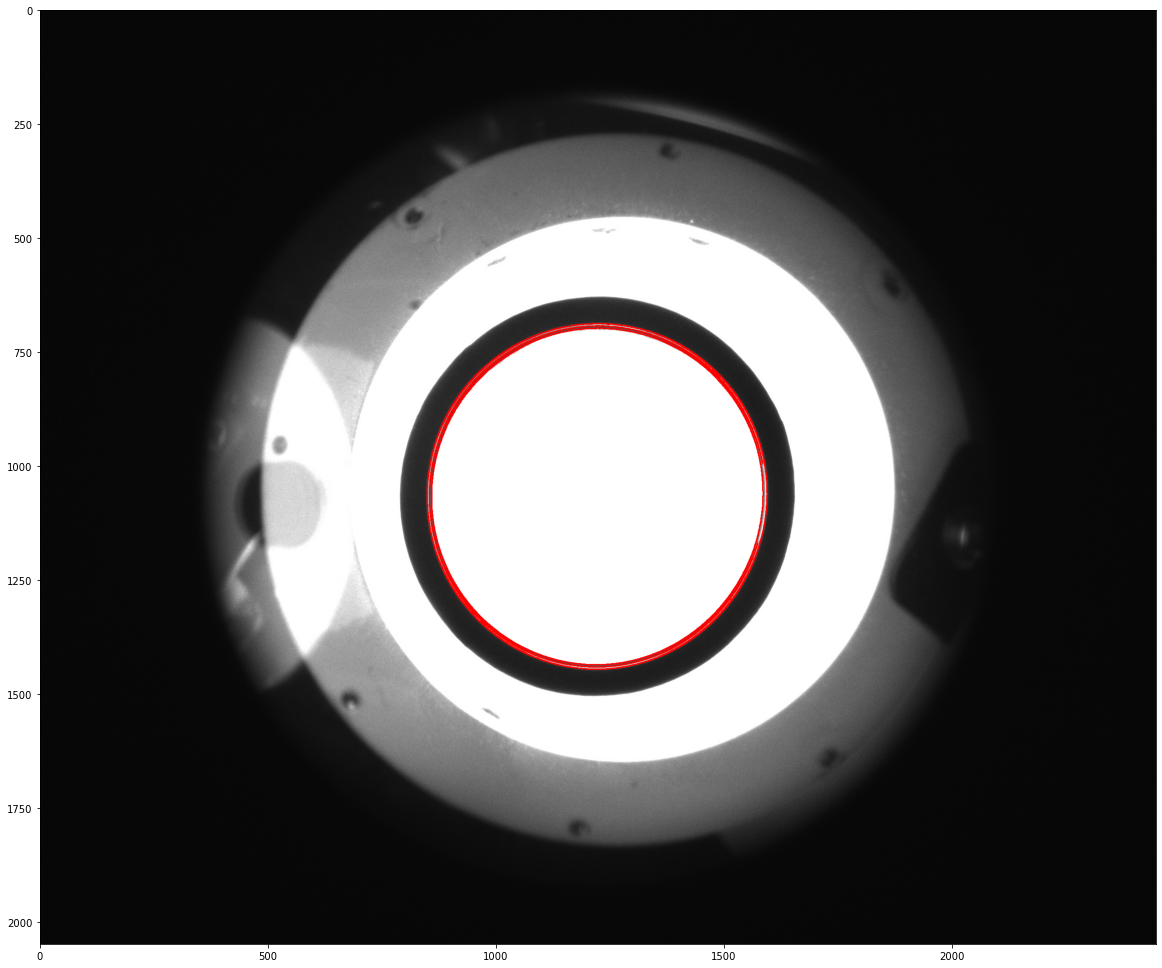

In [818]:
filename = '0525_images/CCD-3/5.jpg'
print(filename)
image = np.array(cv2.imread(filename,0))


plt.figure(figsize=(20,20))
plt.imshow(background,cmap = 'gray')

plt.figure(figsize=(20,20))
plt.imshow(image,cmap = 'gray')

backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

ret, thresh1 = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(20,20))
plt.imshow(thresh1,cmap = 'gray')


#find contours1
_ , contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


contours_final = []
approx_list = []
for i in range(np.array(contours).shape[0]):
        if(cv2.contourArea(contours[i])>300000 and cv2.contourArea(contours[i])<800000):
            contours_final.append(contours[i])
            #cv2.drawContours(backtorgb,contours[i],-1,(0,0,255),3)

            print("Area: ",cv2.contourArea(contours[i]))
            epsilon = 0.5# * cv2.arcLength(contours[i],True)
            approx = cv2.approxPolyDP(contours[i], epsilon, True)
            approx_list.append(approx)
            #cv2.polylines(backtorgb, [approx], True, (255, 0, 0), 2)
            
                
#plt.figure(figsize=(20,20))
#plt.imshow(backtorgb)

inner_contour_img = np.zeros_like(image)
cv2.drawContours(inner_contour_img, [approx_list[1]],-1,(255,255,255),-1)
inner_contour_img = 1 - inner_contour_img
#outer_contour_img = (outer_contour_img ==255).astype(int)

outer_contour_img = np.zeros_like(image)

cv2.drawContours(outer_contour_img, [approx_list[0]],-1,(255,255,255),-1)
outer_contour_img = 1 - outer_contour_img
#inner_contour_img = (inner_contour_img ==255).astype(int)

# for below delete contour after algorithm
delete_contour_img = np.zeros_like(image)
cv2.drawContours(delete_contour_img, [approx_list[0]],-1,(255,255,255),3)

#outer - inner
oringmask = outer_contour_img- inner_contour_img
#plt.figure(figsize=(20,20))
#plt.imshow(oringmask,cmap = 'gray')

mask_image = oringmask*image
#mask_image = 1 - mask_image
image[oringmask != 1] =255
#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')

#==============以上找到Oring
canny = cv2.blur(image,(5,5))

#canny = cv2.Canny(canny,10,28)
canny = cv2.Canny(canny,10,30)
#image = thresh1*image
#plt.figure(figsize=(20,20))
#plt.imshow(canny,cmap = 'gray')


_ , contours, hierarchy = cv2.findContours(canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
inner_contours_final = []
inner_approx_list = []
index = []
for i in range(np.array(contours).shape[0]):
    if (hierarchy[0][i][3] >= 0):
        if(cv2.contourArea(contours[i])>100 and cv2.contourArea(contours[i])<500000):
            #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
            inner_contours_final.append(contours[i])
            epsilon = 0.005# * cv2.arcLength(contours[i],True)
            
            print(cv2.contourArea(contours[i]))
            index.append(i)
            approx = cv2.approxPolyDP(contours[i], epsilon, True)
            approx_list.append(approx)
            cv2.polylines(backtorgb, [approx], True, (255, 0, 0), 2)

plt.figure(figsize=(20,20))
plt.imshow(backtorgb)

inner_contour_img = np.zeros_like(canny)
cv2.drawContours(inner_contour_img, [approx_list[index[0]]],-1,(255,255,255),-1)
#inner_contour_img = 1 - inner_contour_img
image[inner_contour_img == 0] =255

plt.figure(figsize=(20,20))
plt.imshow(image,cmap = 'gray')
#plt.imsave("stop3.jpg",image,cmap = 'gray')
#======================================以上把黑線找出來了======================================

ret, thresh1 = cv2.threshold(image, 80, 255, cv2.THRESH_BINARY_INV)
#thresh1 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,19,12)
#ret, thresh1 = cv2.threshold(image, 80, 255, cv2.THRESH_BINARY_INV)
#plt.figure(figsize=(20,20))
#plt.imshow(thresh1,cmap = 'gray')

open_kernel = np.ones((2,3),np.uint8)
OPEN_image = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, open_kernel)
#plt.figure(figsize=(20,20))
#plt.imshow(OPEN_image,cmap = 'gray')


#close_kernel = np.ones((15,15),np.uint8)
close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
CLOSE_image = cv2.morphologyEx(OPEN_image, cv2.MORPH_CLOSE, close_kernel)
plt.figure(figsize=(20,20))
plt.imshow(CLOSE_image,cmap = 'gray')




#=================================
'''
kernel = np.ones((15,15),np.uint8)  
erosion = cv2.dilate(CLOSE_image,kernel,iterations = 1)
plt.figure(figsize=(20,20))
plt.imshow(erosion,cmap = 'gray')
'''
#==========================================
New_image = np.zeros_like(image)
New_image[CLOSE_image!=0] = 0
New_image[CLOSE_image==0] = 255

#plt.figure(figsize=(20,20))
#plt.imshow(New_image,cmap = 'gray')
#=========================================

backtorgb_OPEN_image = cv2.cvtColor(New_image,cv2.COLOR_GRAY2RGB)
_ , contours, hierarchy = cv2.findContours(New_image,cv2.RETR_TREE  ,cv2.CHAIN_APPROX_SIMPLE)
inner_contours_final = []
inner_approx_list = []
index = []
shapes = np.zeros((1,1,2),np.uint8)

for i in range(np.array(contours).shape[0]):
    #if(i==2):
    if(i>0 ):
        #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
        inner_contours_final.append(contours[i])
        shapes = np.append(shapes,np.array(contours[i]).reshape(-1,1,2),axis = 0)
        epsilon = 0.05# * cv2.arcLength(contours[i],True)
        index.append(i)
        approx = cv2.approxPolyDP(contours[i], epsilon, True)
        approx_list.append(approx)
        #cv2.polylines(backtorgb_OPEN_image, [approx], True, (255, 0, 0), 2)
        
        #print(approx.reshape(-1,1,2))
        '''
        boundRect = cv2.minAreaRect(approx)
        boundRect = cv2.boxPoints(boundRect)
        boundRect = np.int0(boundRect)
        print(boundRect)
        '''
        #cv2.drawContours(backtorgb_OPEN_image, [boundRect], 0, (0, 255, 0), 3 );
        #cv2.circle(backtorgb_OPEN_image,(approx[0][0][0],approx[0][0][1]), 8, (0,0 ,0), -1)
        #cv2.circle(backtorgb_OPEN_image,(approx[approx.shape[0]//2][0][0],approx[approx.shape[0]//2][0][1]), 8, (0,255 ,0), -1)
        #cv2.rectangle(backtorgb_OPEN_image, (int(boundRect[0]), int(boundRect[1])),(int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (0,0 ,255), 4)
        cv2.drawContours(backtorgb_OPEN_image, [approx], 0, (255, 0, 0), -1 );
        #print(approx.shape)
        
#approx = cv2.approxPolyDP([approx_list], epsilon, True)
 

New_image = np.zeros_like(image)
New_image[backtorgb_OPEN_image[...,2]==255]=0
New_image[backtorgb_OPEN_image[...,2]!=255]=255

#open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
New_image_OPEN = cv2.morphologyEx(CLOSE_image, cv2.MORPH_OPEN, open_kernel)

'''
#close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,21))
#kernel = np.ones((30,30),np.uint8)  
#New_image_CLOSED = cv2.morphologyEx(New_image_OPEN, cv2.MORPH_CLOSE, close_kernel)   

#close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(200,200))
#kernel = np.ones((30,30),np.uint8)  
#New_image_CLOSED2 = cv2.morphologyEx(New_image_CLOSED, cv2.MORPH_CLOSE, close_kernel)  
'''


#========test for find defect=========================
#New_image_OPEN = CLOSE_image 
plt.figure(figsize=(20,20))
plt.imshow(New_image_OPEN,cmap = 'gray')
#======================================================
backtorgb_OPEN_image = cv2.cvtColor(New_image_OPEN,cv2.COLOR_GRAY2RGB)
_ , contours, hierarchy = cv2.findContours(New_image_OPEN,cv2.RETR_CCOMP  ,cv2.CHAIN_APPROX_NONE)
inner_contours_final = []
inner_approx_list = []
index = []
shapes = np.zeros((1,1,2),np.uint8)

for i in range(np.array(contours).shape[0]):
    #if(i==2):
    if(cv2.contourArea(contours[i])>5 and cv2.contourArea(contours[i])<500000):
        #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
        inner_contours_final.append(contours[i])
        shapes = np.append(shapes,np.array(contours[i]).reshape(-1,1,2),axis = 0)
        epsilon = 5# * cv2.arcLength(contours[i],True)
        index.append(i)
        approx = cv2.approxPolyDP(contours[i], epsilon, False)
        approx_list.append(approx)
        #cv2.circle(backtorgb_OPEN_image,(approx[0][0][0],approx[0][0][1]), 8, (0,255 ,0), -1)
        #cv2.circle(backtorgb_OPEN_image,(approx[-1][0][0],approx[-1][0][1]), 8, (0,255 ,0), -1)
        #cv2.drawContours(backtorgb_OPEN_image, [approx], 0, (255, 0, 0), -1 );
        #print(approx.shape)

shapes = shapes[1:]
epsilon = 20
approx = cv2.approxPolyDP(shapes, epsilon, False)
'''
#defects = cv2.convexityDefects(shapes,hull)
print(approx.shape)
cv2.drawContours(backtorgb_OPEN_image, [approx], 0, (255, 255, 255), -1 );
'''

c,r = cv2.minEnclosingCircle(approx)
r = int(r)
cx = int(c[0])
cy = int(c[1])
print(int(c[0]))
New_image = np.zeros_like(image)
New_image[backtorgb_OPEN_image[...,2]==255]=255
New_image[backtorgb_OPEN_image[...,2]!=255]=0
cv2.circle(backtorgb_OPEN_image,(cx,cy),(r+5), (0,255 ,0), 3)
for degree in range(1000):
    x = int((r+5)*np.sin(degree))+cx
    y = int((r+5)*np.cos(degree))+cy
    
    points_on_line = np.linspace((int(c[0]), int(c[1])),(x,y) ,500,dtype = int)
    pass_list = New_image_OPEN[points_on_line[:,1],points_on_line[:,0]]
    if(sum(pass_list)<=1000):
        cv2.line(backtorgb_OPEN_image,(int(c[0]),int(c[1])),(x,y),255,2)
        cv2.circle(backtorgb_OPEN_image,(x,y),15, (0,255 ,255), 5)
plt.figure(figsize=(20,20))
plt.imshow(backtorgb_OPEN_image)


## Temp

In [ ]:
filename = '0525_images/CCD-3/18.jpg'
print(filename)
image = np.array(cv2.imread(filename,0))
backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

#==============================================先用canny找出輪廓=============================================

#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')

image_blur = cv2.blur(image,(5,5))
canny = cv2.Canny(image_blur,5,15)
#plt.figure(figsize=(20,20))
#plt.imshow(canny,cmap = 'gray')

#==============================================用findcontours把canny得到的 ROI切出來=======================================

_ , contours, hierarchy = cv2.findContours(canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
inner_contours_final = []
approx_list = []
index = []
for i in range(np.array(contours).shape[0]):
    if (hierarchy[0][i][3] >= 0):
        if(cv2.contourArea(contours[i])>300000 and cv2.contourArea(contours[i])<500000):
            #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
            #inner_contours_final.append(contours[i])
            epsilon = 0.005# * cv2.arcLength(contours[i],True)
            index.append(i)
            approx = cv2.approxPolyDP(contours[i], epsilon, True)
            print(cv2.contourArea(approx))
            approx_list.append(approx)
            #print(np.array(approx_list).shape)
            cv2.polylines(backtorgb, [approx], True, (255,0, 0), 3)

plt.figure(figsize=(20,20))
plt.imshow(backtorgb)

#==========================================外圓減內圓(外圓是面積最大那一個，index = 0 ，內圓面積最小，index = -1)

inner_contour_img = np.zeros_like(image)
cv2.drawContours(inner_contour_img, [approx_list[-1]],-1,(0,0,0),-1)
#inner_contour_img = 1 - inner_contour_img

outer_contour_img = np.zeros_like(image)
cv2.drawContours(outer_contour_img, [approx_list[0]],-1,(255,255,255),-1)
#outer_contour_img = 1 - outer_contour_img

#outer - inner
#oringmask = outer_contour_img- inner_contour_img
oringmask = outer_contour_img
#plt.figure(figsize=(20,20))
#plt.imshow(oringmask,cmap = 'gray')


mask_image = oringmask*image
#mask_image = 1 - mask_image
image[oringmask == 0] =255
plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')
#plt.imsave("temp.jpg",image,cmap = 'gray')
backtorgb_inner_oring = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
#==========================================找外接圓==============================================
ret, thresh1 = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY_INV)

c,r = cv2.minEnclosingCircle(approx_list[0])
r = int(r)
cx = int(c[0])
cy = int(c[1])
print(r," ",cx," ",cy)
cv2.circle(backtorgb_inner_oring,(cx,cy),(r+5), (0,255 ,0), 3)

#================================================從圓心射線================================
image = cv2.blur(image,(3,3))
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
image = cv2.filter2D(image, -1, kernel)
#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')


ret, image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY_INV)

open_kernel = np.ones((2,3),np.uint8)
#open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,3))
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, open_kernel)

plt.figure(figsize=(20,20))
plt.imshow(image,cmap = 'gray')
plt.imsave("temp.jpg",thresh1,cmap = 'gray')

#=====blur image=====
#image = cv2.blur(image,(2,3))
#=====================

const = np.pi/180
x = []
y = []
inner_x = []
inner_y = []

for degree in range(360):
    
    now_x = int((r+2)*np.sin(degree*const))+cx
    now_y = int((r+2)*np.cos(degree*const))+cy
    now_inner_x = int((r-30)*np.sin(degree*const))+cx
    now_inner_y = int((r-30)*np.cos(degree*const))+cy
    
    if(degree>0):
        prev_x = x[-1]
        prev_y = y[-1]
        prev_inner_x = inner_x[-1]
        prev_inner_y = inner_y[-1]
        
        x.append((now_x+prev_x)//2)
        y.append((now_y+prev_y)//2)
        inner_x.append((now_inner_x+prev_inner_x)//2)
        inner_y.append((now_inner_y+prev_inner_y)//2)
        
    x.append(now_x)
    y.append(now_y)
    inner_x.append(now_inner_x)
    inner_y.append(now_inner_y)

for degree in range(719):
    points_on_line = np.linspace((inner_x[degree], inner_y[degree]),(x[degree],y[degree]) ,200,dtype = int)
    pass_list = image[points_on_line[:,1],points_on_line[:,0]]
    if(degree >= 700 and degree <=720):
    #if(sum(pass_list[pass_list<120])<=5000 and sum(pass_list[pass_list<120])>=4000):
    #if(np.mean(pass_list[pass_list<230])>150):
    #if(len(pass_list[pass_list==255])<15):
        #cv2.line(backtorgb_inner_oring,(cx,cy),(x,y),255,2)
        print(len(pass_list[pass_list==255])," ", np.mean(pass_list[pass_list==255]))
        cv2.line(backtorgb_inner_oring,(inner_x[degree],inner_y[degree]),(x[degree],y[degree]),255,2)
        #cv2.circle(backtorgb_inner_oring,(x,y),30, (0,255 ,255), 5)
        #print(np.mean(pass_list[pass_list<100]))
        #print(sum(pass_list[pass_list<80]))

plt.figure(figsize=(20,20))
plt.imshow(backtorgb_inner_oring)
plt.imsave("stop3.jpg",backtorgb_inner_oring)
#======================pipeline========================
'''
1.找到那一圈黑色的
2.找外接圓
3.從圓心往外射，看射到的pixel 0 和255分布(0太少表示是斷裂)

想法:degree太少，插入幾根在這些degree當中(本來是1度一單位)
'''
#======================parameter=======================

